In [1]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

## Part 1: Data preparation

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

In [7]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


In [9]:
train_images = np.array(train_images)

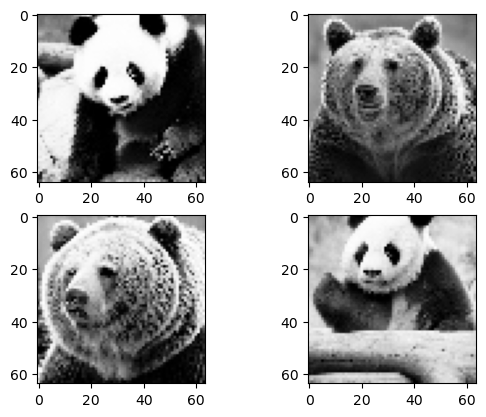

In [11]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

# Part 2: Singular value decomposition

In [15]:
# Constants
size = (128, 128)

In [17]:
# Create data matrix
bear_matrix = []
for i in range(len(train_images)):
	bear_matrix.append(np.ravel(train_images[i]))

bear_df = pd.DataFrame(np.array(bear_matrix).T)

In [19]:
# Normalize data matrix
avgBear = np.mean(bear_df, axis = 1)
bears_norm = bear_df - np.tile(avgBear, ( bear_df.shape[1], 1 )).T

In [21]:
# Compute SVD
U, S, Vh = np.linalg.svd(bears_norm)

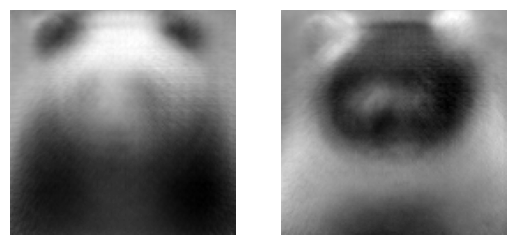

In [23]:
# View average and eigenface
fig1 = plt.figure()

ax1 = fig1.add_subplot(121)
img_avg = plt.imshow(np.reshape(np.array(avgBear), size))
img_avg.set_cmap("gray")
plt.axis("off")

ax2 = fig1.add_subplot(122)
img_u1 = ax2.imshow(np.reshape(U[:, 0], size))
img_u1.set_cmap("gray")
plt.axis("off")

plt.show()

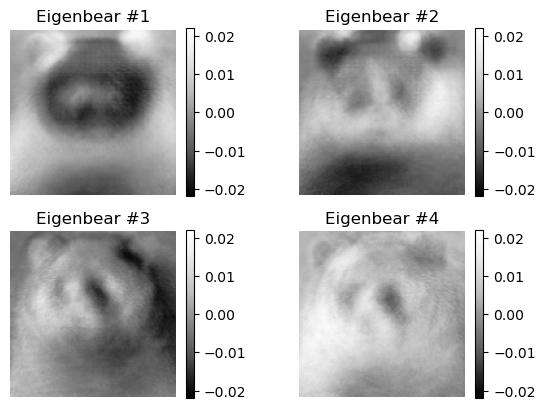

In [25]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()

    plt.axis("off")
    plt.title(f"Eigenbear #{i + 1}")
plt.subplots_adjust(wspace=0.4)

Eigenbear #1 has the sharpest and most coherent-looking image, actually looking the most like a bear in terms of outline. As we move forward in the eigenvector hierarchy, each successive "eigenbear" becomes less coherent with greater levels of blur and lower contrast (less difference between the high- and low-value parts). Interestingly enough, the contrast between dark and light spots in Eigenbear #3 makes it look almost more bearlike than Eigenbear #2 to the naked eye---it seems very recognizable as a panda.

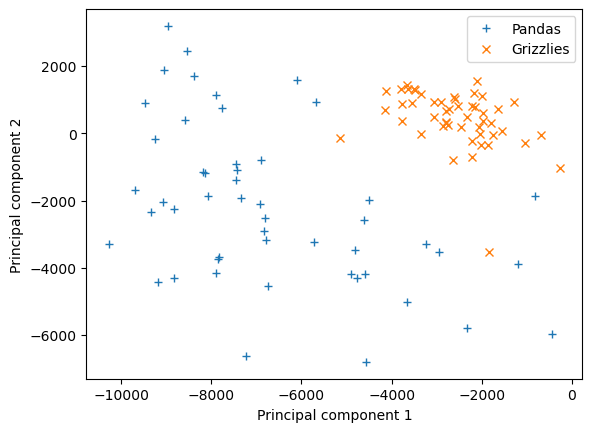

In [28]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

The pandas and the grizzlies are very distinguishable from one another across the first two principal components, forming two distinct clusters. They are very separated from one another along a spectrum on the PC1-PC2 line. Pandas have low/negative values of PC1 and PC2 while grizzlies are very concentrated in the upper-right coordinates of the graph. Interestingly, there is more spread in the data on pandas, while the grizzlies are all clustered very close together.

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

# Part 3: Nonparametric classification

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [37]:
# Create bear_df test set
bear_matrix_test = []
for i in range(len(test_images)):
	bear_matrix_test.append(np.ravel(test_images[i]))

bear_test_df = pd.DataFrame(np.array(bear_matrix_test).T)

In [39]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(bear_df.T, y_train)

    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(bear_test_df[i])]) for i in range(len(y_test))]
    
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      1 	| [4]
    2	|      0 	| []
    3	|      2 	| [ 4 29]
    4	|      1 	| [29]
    5	|      3 	| [ 4  8 29]
    6	|      2 	| [ 8 29]
    7	|      4 	| [ 8 29 34 45]
    8	|      2 	| [29 34]
    9	|      4 	| [ 5  8 29 34]
    10	|      3 	| [ 5 29 34]
    11	|      4 	| [ 5 29 34 45]
    12	|      4 	| [ 5 29 34 45]
    13	|      5 	| [ 4  5 29 34 45]
    14	|      5 	| [ 4  5 29 34 45]
    15	|      7 	| [ 2  4  5  9 29 34 45]


The best test accuracy is from k = 2, where no bears were misclassified.

There seems to be consistent difficulty in classifying bears 2, 4, 5, 8, 9, 29, 34, and 45, which are the eight images that are misidentified in at least one model.

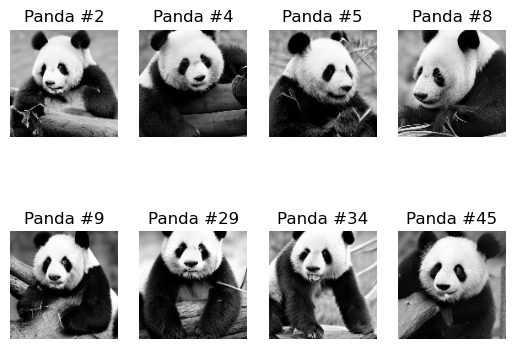

In [42]:
# Show hard-to-classify bears
fig1 = plt.figure()

### DEF: create subplot in figure
def subplot(image, number, index):
	ax = fig1.add_subplot(number)
	img = ax.imshow(np.reshape(np.array(image), size))
	img.set_cmap("gray")
	plt.axis("off")
	plt.title(f"Panda #{index}")

subplot(bear_test_df[2], 241, 2)
subplot(bear_test_df[4], 242, 4)
subplot(bear_test_df[5], 243, 5)
subplot(bear_test_df[8], 244, 8)
subplot(bear_test_df[9], 245, 9)
subplot(bear_test_df[29], 246, 29)
subplot(bear_test_df[34], 247, 34)
subplot(bear_test_df[45], 248, 45)

misclass_set = [2, 4, 5, 8, 9, 29, 34, 45]

plt.show()

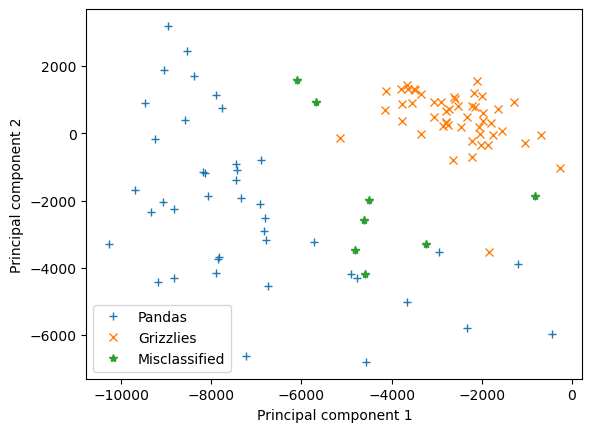

In [44]:
# REDO clustering of panda bears and brown bears along the first and second principal component
# and highlight the eight misclassified bears

# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears, misclass_set]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x*'[i], lw=0, label=['Pandas', 'Grizzlies', 'Misclassified'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

Numerically, we can see that all of the misclassified images lie on the border between the Pandas cluster and the Grizzlies cluster in the PC1-PC2 plane, making them difficult to classify when they could all be misidentified as neighboring one or the other.

Qualitatively, a big classifier on whether a bear is a panda or a grizzly is with the grizzly's more ruffled fur and its unique shape.

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

# Part 4: Parametric classification

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [51]:
# Logistic Regression model
model_log = LogisticRegression().fit(bear_df.T, y_train)

predictions = [model_log.predict([np.ravel(bear_test_df[i])]) for i in range(len(y_test))]
errors = np.abs((np.array(predictions).T)[0]-y_test)

print("LOGISTIC REGRESSION MODEL")
print('# errors\t| misclassified bears')
print('--------------------------------------------')
print('{} \t\t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

LOGISTIC REGRESSION MODEL
# errors	| misclassified bears
--------------------------------------------
15 		| 0


In [53]:
# Linear Discriminant Analysis model
model_lda = LinearDiscriminantAnalysis().fit(bear_df.T, y_train)

predictions = [model_lda.predict([np.ravel(bear_test_df[i])]) for i in range(len(y_test))]
errors = np.abs((np.array(predictions).T)[0]-y_test)

print("LINEAR DISCRIMINANT ANALYSIS MODEL")
print('# errors\t| misclassified bears')
print('--------------------------------------------')
print('{} \t\t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

LINEAR DISCRIMINANT ANALYSIS MODEL
# errors	| misclassified bears
--------------------------------------------
15 		| 1


There are significantly more "errors" (15) with the parametric system, although there are still very few (0 and 1) actual misidentifications.

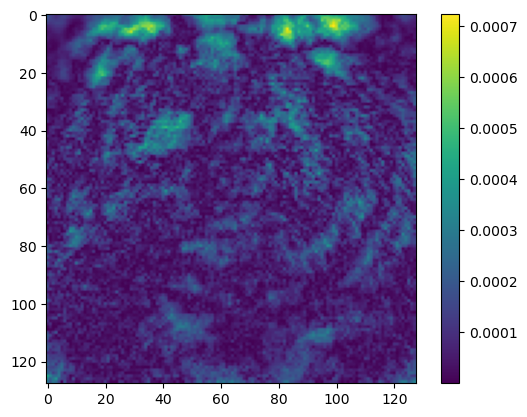

In [56]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((model_log.coef_).reshape((128,128))))
plt.colorbar()

The bear mask has very strong but largely uniform fur-like spots, which is indicative of a grizzly bear rather than a panda bear. If the mask were reflective of a panda bear, we would expect to see strong divides as per the panda's black and white spots/regions of fur, alongside generally more internally uniform and less sharply fuzzy areas.

This tells me that the logistic regression mechanism checks if a bear is a grizzly by comparing it against the mask. Images that fail the check are then listed as pandas.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

# Part 5: Robustness to additive white noise

I ran the code as specified, but have since rerun it with add_noise = False again to double-check my work. Thus, if any plots or images are visible on the GitHub submission, they likely correspond to add_noise = False, and this parameter is set to False in the code above.

Running the entire program (incl. all three classification models) with add_noise = True yields very similar results, indicating a level of robustness to many classification mechanisms in the presence of white noise.

For the k-nearest-neighbors model: the amount of errors across k-values was still roughly the same, and k = 2 is still the most accurate with zero errors and zero misclassified bears. Eight bears were still misidentified, all of whom were already misidentified in the original model.

For the logistic regression model: there were still 15 errors, as before, but now with one misclassified bear as opposed to zero.

The logistic regression's bear mask still produces the same pattern -- this actually looks like the same exact image but if the image were also put through a white noise filter.

The linear discriminant analysis model was unaffected by the white noise: there were still 15 errors with one misclassification.

Overall, we can see that white noise does not significantly affect our classification models: we can simply see that our eigenbears and the bear mask account for the noise by also being put through white noise filtering.

Since white noise filtering is uniform across all frequencies, we might expect that filtering the image with non-uniform noise across the low and high frequencies (from a signal processing perspective) of the image or even across different color values (e.g. different noise amounts for white versus black parts of the image) might lead to errors in classification, especially if our filtering mechanism can reduce overall contrast in our images.